In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/fake-news-detection")

print("Path to dataset files:", path)

100%|██████████| 41.0M/41.0M [00:00<00:00, 106MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/bhavikjikadara/fake-news-detection/versions/1


In [ ]:
!pip install scikit-learn torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import kagglehub
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

csv_file_path = os.path.join(path, 'fake.csv')  # Update if the actual file name differs

# Load the dataset
df = pd.read_csv(csv_file_path)

# If label column isn't present, assign label 0 (fake)
if 'label' not in df.columns:
    df['label'] = 0  # Assume all fake.csv entries are fake news

# Drop rows with missing text
df = df.dropna(subset=['text'])

# Shuffle dataset (optional)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['text']).toarray()
y = df['label'].values  # Binary labels (0 = fake, 1 = real)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes + 1)  # 2 real classes + 1 fake class
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Hyperparameters
noise_dim = 100
input_dim = X_train.shape[1]
batch_size = 64
epochs = 10

# Initialize models and optimizers
gen = Generator(noise_dim, input_dim)
disc = Discriminator(input_dim)
g_opt = optim.Adam(gen.parameters(), lr=0.001)
d_opt = optim.Adam(disc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    permutation = torch.randperm(X_train.size(0))

    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        real_data = X_train[indices]
        real_labels = y_train[indices]

        b_size = real_data.size(0)

        # ---- Train Discriminator ----
        z = torch.randn(b_size, noise_dim)
        fake_data = gen(z).detach()

        real_output = disc(real_data)
        fake_output = disc(fake_data)

        # real class = 0 or 1, fake class = 2
        real_targets = real_labels
        fake_targets = torch.full((b_size,), 2, dtype=torch.long)

        d_loss_real = criterion(real_output, real_targets)
        d_loss_fake = criterion(fake_output, fake_targets)
        d_loss = d_loss_real + d_loss_fake

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        # ---- Train Generator ----
        z = torch.randn(b_size, noise_dim)
        gen_data = gen(z)
        d_output = disc(gen_data)

        # Try to fool discriminator: assign real labels randomly (0 or 1)
        g_targets = torch.randint(0, 2, (b_size,))
        g_loss = criterion(d_output, g_targets)

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch [1/10], D Loss: 0.4981, G Loss: 3.0194
Epoch [2/10], D Loss: 0.9844, G Loss: 2.6999
Epoch [3/10], D Loss: 0.5086, G Loss: 3.4609
Epoch [4/10], D Loss: 0.7588, G Loss: 3.2097
Epoch [5/10], D Loss: 0.7128, G Loss: 5.0999
Epoch [6/10], D Loss: 0.9816, G Loss: 4.1087
Epoch [7/10], D Loss: 0.6042, G Loss: 4.0050
Epoch [8/10], D Loss: 0.6762, G Loss: 3.5768
Epoch [9/10], D Loss: 0.3020, G Loss: 3.4218
Epoch [10/10], D Loss: 1.3474, G Loss: 5.7337


In [ ]:
with torch.no_grad():
    test_output = disc(X_test)
    preds = torch.argmax(test_output[:, :2], dim=1)
    acc = (preds == y_test).float().mean()
    print(f"\n🎯 Test Accuracy: {acc.item():.4f}")



🎯 Test Accuracy: 1.0000


In [ ]:
import random

# Function to classify a single news article
def classify_random_article(gen, disc, vectorizer, filepath='fake.csv'):
    import pandas as pd
    import torch

    # Load the dataset
    # df = pd.read_csv(filepath)
    df = pd.read_csv(csv_file_path)

    if 'label' not in df.columns:
        df['label'] = 0  # All samples from fake.csv assumed fake

    # Drop rows with missing text
    df = df.dropna(subset=['text']).reset_index(drop=True)

    # Pick a random sample
    idx = random.randint(0, len(df) - 1)
    text = df.loc[idx, 'text']
    true_label = df.loc[idx, 'label']

    # Vectorize the text using the same TF-IDF vectorizer
    text_vector = vectorizer.transform([text]).toarray()
    text_tensor = torch.tensor(text_vector, dtype=torch.float32)

    # Get prediction from discriminator
    disc.eval()
    with torch.no_grad():
        output = disc(text_tensor)
        pred_class = torch.argmax(output[:, :2], dim=1).item()

    label_map = {0: 'Fake', 1: 'Real'}
    print("📰 Random News Article:")
    print("-----------------------------------------------------")
    print(text[:1000] + ("..." if len(text) > 1000 else ""))
    print("-----------------------------------------------------")
    print(f"✅ Predicted Class: {label_map[pred_class]}")
    print(f"🎯 True Label: {label_map[true_label]}")

# ⚠️ Call this only after training. It uses the trained `disc`, `vectorizer`.
classify_random_article(gen, disc, vectorizer)


📰 Random News Article:
-----------------------------------------------------
At least two Republican campaigns are using veteran s groups as props for campaign debate stunts.The stomach-turning trend began with Super PACs backing Senator Ted Cruz (R-TX), who responded to Donald Trump pulling out of the officially sanctioned Republican presidential debate by offering a ransom for Trump to appear in a one-on-one event.Super PACs supporting Republican presidential candidate Ted Cruz say they will donate $1.5 million to charities committed to helping veterans if rival Donald Trump agrees to a one-on-one debate with Cruz. Not only would this be a heck of a debate, but it would also be a terrific opportunity to generate millions of dollars for the veterans,  the Keep the Promise I and II PACs said in a joint statement Wednesday night.Former HP CEO Carly Fiorina, who is mired in the single digits in her campaign later chimed in, promising to donate $1.5 million to veterans to join in a Cruz-T

In [ ]:
# Function to classify a specific row (by index) from the dataset
def classify_article_by_row(gen, disc, vectorizer, row_index, filepath='fake.csv'):
    import pandas as pd
    import torch

    # Load the dataset
    # df = pd.read_csv(filepath)
    df = pd.read_csv(csv_file_path)

    # If label not present, assume all fake
    if 'label' not in df.columns:
        df['label'] = 0

    # Drop rows with missing text
    df = df.dropna(subset=['text']).reset_index(drop=True)

    # Check if row_index is valid
    if row_index >= len(df) or row_index < 0:
        print(f"⚠️ Invalid row index {row_index}. Dataset has {len(df)} rows.")
        return

    # Get the text and label
    text = df.loc[row_index, 'text']
    true_label = df.loc[row_index, 'label']

    # Vectorize text
    text_vector = vectorizer.transform([text]).toarray()
    text_tensor = torch.tensor(text_vector, dtype=torch.float32)

    # Predict class using the discriminator
    disc.eval()
    with torch.no_grad():
        output = disc(text_tensor)
        pred_class = torch.argmax(output[:, :2], dim=1).item()

    label_map = {0: 'Fake', 1: 'Real'}
    print(f"📰 News Article at Row {row_index}:")
    print("-----------------------------------------------------")
    print(text[:1000] + ("..." if len(text) > 1000 else ""))
    print("-----------------------------------------------------")
    print(f"✅ Predicted Class: {label_map[pred_class]}")
    print(f"🎯 True Label: {label_map[true_label]}")

# 🔍 Example usage:
# Get classification result for row 10 (change to any index you want)
classify_article_by_row(gen, disc, vectorizer, row_index=10)


📰 News Article at Row 10:
-----------------------------------------------------
A centerpiece of Donald Trump s campaign, and now his presidency, has been his white supremacist ways. That is why so many of the public feuds he gets into involve people of color. One of his favorite targets, is, of course, the players in the National Football League who dare to exercise their First Amendment rights by kneeling during the national anthem in protest of racist police brutality. Well, there is one person who has figured out that racism is bad for business, even if it did get the orange overlord elected: The founder of the pizza chain Papa John s.This is a man who has never been on the right side of history on any number of issues, and plus his pizza sucks. But, when he decided to complain about the players protesting, his sales really dropped. Turns out racism doesn t pay, and we all know that corporations are all about the bottom line. Therefore, Papa John Schnatter will no longer be CEO of 

In [ ]:
# Get classification result for row 100 (change to any index you want)
classify_article_by_row(gen, disc, vectorizer, row_index=100)

# Get classification result for row 123 (change to any index you want)
classify_article_by_row(gen, disc, vectorizer, row_index=123)

📰 News Article at Row 100:
-----------------------------------------------------
Former Vice President Joe Biden was asked on Monday by Matt Lauer on NBC s  Today  to name something specific that Donald Trump has been  doing well. Well, that seems like a trick question since Trump has passed no major legislation and reaches across the aisle only to take shots at Democrats in his Twitter timeline during his morning rage-tweets, so Biden struggled to find something, anything, that Trump has done well since taking office. I think there s a number of things he s doing well. But even the things he s doing well, it s how he does them,  Biden said. It s more the tone of this administration that bothers me,  he continued. With all due respect, you haven t come up with one thing you think he s doing well,  Lauer said. Well, I think he married very well,  Biden joked.Although, Biden didn t mention which of Trump s three marriages he s speaking of. Trump s first marriage to Ivana ended after he h

# New

🎯 Epoch 1/50
🧠 D Loss: 1.4487 | 🎨 G Loss: 0.6321
📈 Accuracy: 0.2725 | 🎯 Precision: 0.3528 | 📉 Recall: 0.5450 | 🧪 F1-Score: 0.4283

🎯 Epoch 2/50
🧠 D Loss: 1.4455 | 🎨 G Loss: 0.6471
📈 Accuracy: 0.2800 | 🎯 Precision: 0.3590 | 📉 Recall: 0.5600 | 🧪 F1-Score: 0.4375

🎯 Epoch 3/50
🧠 D Loss: 1.4124 | 🎨 G Loss: 0.6658
📈 Accuracy: 0.2925 | 🎯 Precision: 0.3691 | 📉 Recall: 0.5850 | 🧪 F1-Score: 0.4526

🎯 Epoch 4/50
🧠 D Loss: 1.3941 | 🎨 G Loss: 0.6807
📈 Accuracy: 0.2625 | 🎯 Precision: 0.3443 | 📉 Recall: 0.5250 | 🧪 F1-Score: 0.4158

🎯 Epoch 5/50
🧠 D Loss: 1.3653 | 🎨 G Loss: 0.6938
📈 Accuracy: 0.6150 | 🎯 Precision: 0.6322 | 📉 Recall: 0.5500 | 🧪 F1-Score: 0.5882

🎯 Epoch 6/50
🧠 D Loss: 1.3536 | 🎨 G Loss: 0.7086
📈 Accuracy: 0.7975 | 🎯 Precision: 0.9837 | 📉 Recall: 0.6050 | 🧪 F1-Score: 0.7492

🎯 Epoch 7/50
🧠 D Loss: 1.3466 | 🎨 G Loss: 0.7236
📈 Accuracy: 0.8050 | 🎯 Precision: 1.0000 | 📉 Recall: 0.6100 | 🧪 F1-Score: 0.7578

🎯 Epoch 8/50
🧠 D Loss: 1.3167 | 🎨 G Loss: 0.7348
📈 Accuracy: 0.8175 | 🎯 Precision: 

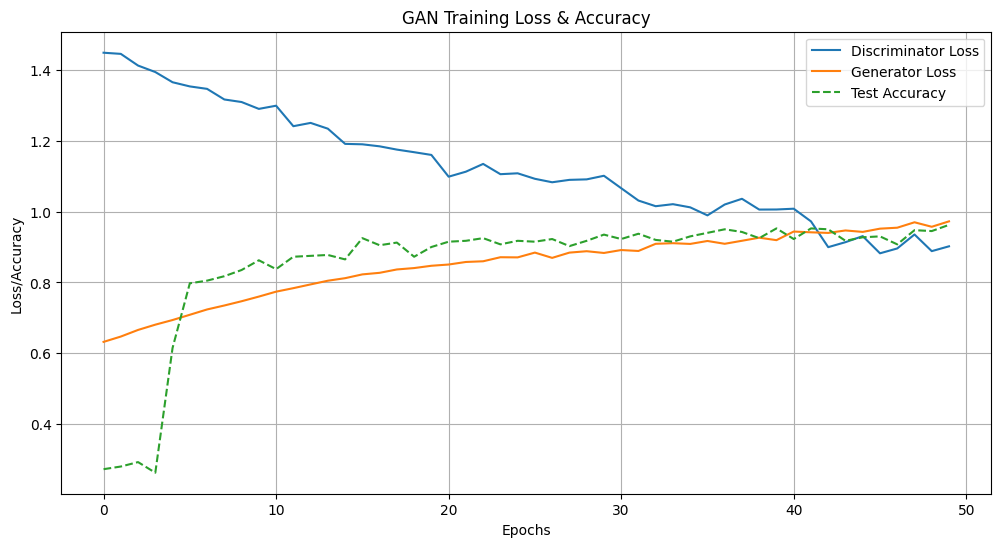

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# ✅ Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Generator model
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

# ✅ Discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ✅ Hyperparameters
input_dim = 10
noise_dim = 10
epochs = 50
batch_size = 64
lr = 0.0002

# ✅ Dummy real data (you can replace with actual data)
real_data = torch.randn(1000, input_dim).to(device)

# ✅ Models
G = Generator(noise_dim, input_dim).to(device)
D = Discriminator(input_dim).to(device)

# ✅ Optimizers
g_optimizer = optim.Adam(G.parameters(), lr=lr)
d_optimizer = optim.Adam(D.parameters(), lr=lr)

# ✅ Loss
criterion = nn.BCELoss()

# ✅ Tracking
d_losses, g_losses, test_accuracies = [], [], []

# ✅ Training loop
for epoch in range(epochs):
    for _ in range(real_data.size(0) // batch_size):
        # Real data
        real_samples = real_data[torch.randint(0, real_data.size(0), (batch_size,))]

        # Fake data
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(noise)

        # Discriminator
        D.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_preds = D(real_samples)
        fake_preds = D(fake_samples.detach())

        real_loss = criterion(real_preds, real_labels)
        fake_loss = criterion(fake_preds, fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Generator
        G.zero_grad()
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(noise)
        fake_preds = D(fake_samples)
        g_loss = criterion(fake_preds, real_labels)  # Try to fool D
        g_loss.backward()
        g_optimizer.step()

    # Track losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    # Generate test set
    noise = torch.randn(200, noise_dim).to(device)
    fake_test = G(noise).detach()
    real_test = real_data[torch.randint(0, real_data.size(0), (200,))]

    # Evaluate D
    test_samples = torch.cat([real_test, fake_test], dim=0)
    test_labels = torch.cat([torch.ones(200), torch.zeros(200)]).cpu().numpy()

    with torch.no_grad():
        test_output = D(test_samples).cpu()
        preds = (test_output.squeeze() > 0.5).int().numpy()

    acc = accuracy_score(test_labels, preds)
    precision = precision_score(test_labels, preds, zero_division=0)
    recall = recall_score(test_labels, preds, zero_division=0)
    f1 = f1_score(test_labels, preds, zero_division=0)

    test_accuracies.append(acc)

    print(f"🎯 Epoch {epoch+1}/{epochs}")
    print(f"🧠 D Loss: {d_loss.item():.4f} | 🎨 G Loss: {g_loss.item():.4f}")
    print(f"📈 Accuracy: {acc:.4f} | 🎯 Precision: {precision:.4f} | 📉 Recall: {recall:.4f} | 🧪 F1-Score: {f1:.4f}\n")

# ✅ Plotting
plt.figure(figsize=(12, 6))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.plot(test_accuracies, label="Test Accuracy", linestyle="--")
plt.legend()
plt.title("GAN Training Loss & Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.grid(True)
plt.show()


📦 Downloaded files: ['true.csv', 'fake.csv']
🎯 Accuracy: 0.9855233853006682
🎯 Precision: 0.9885898815931109
🎯 Recall: 0.9835082458770614
🎯 F1 Score: 0.9860425166416148

🧾 Classification Report:
               precision    recall  f1-score   support

        FAKE       0.99      0.98      0.99      4669
        REAL       0.98      0.99      0.98      4311

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


📊 Confusion Matrix:
 [[4592   77]
 [  53 4258]]


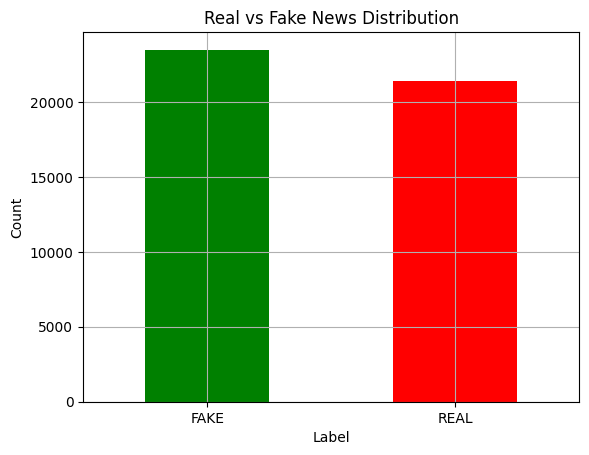

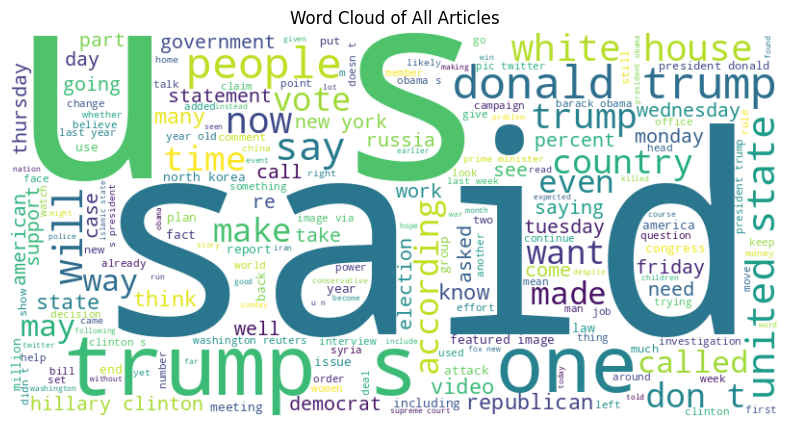

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


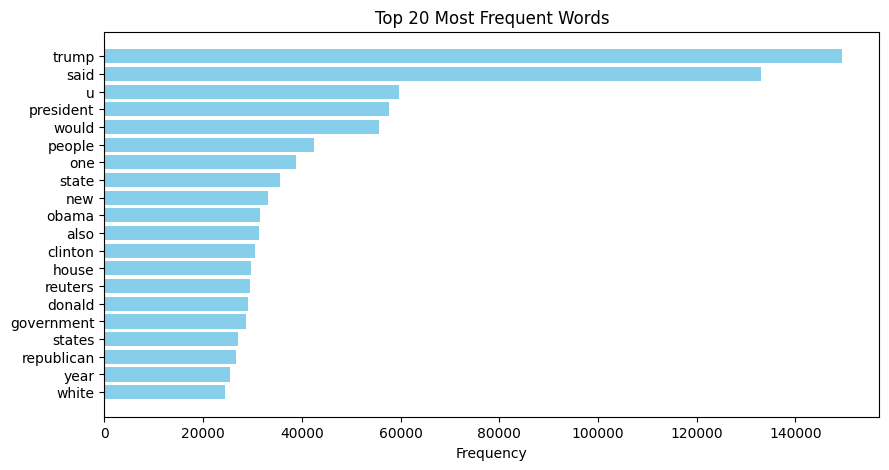

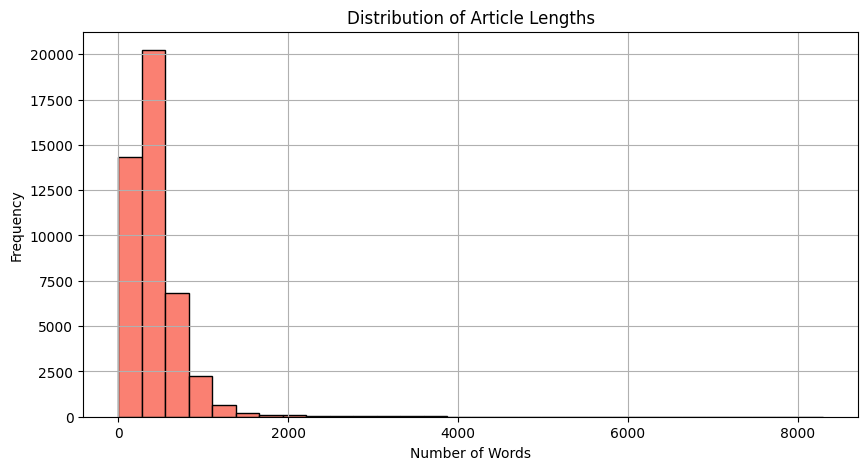

In [ ]:
import os
import pandas as pd
import kagglehub
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# ✅ Download and Load Dataset
dataset_path = kagglehub.dataset_download("bhavikjikadara/fake-news-detection")
print("📦 Downloaded files:", os.listdir(dataset_path))

# ✅ Load true and fake CSV files
true_df = pd.read_csv(f"{dataset_path}/true.csv")
fake_df = pd.read_csv(f"{dataset_path}/fake.csv")

# ✅ Add labels
true_df['label'] = 'REAL'
fake_df['label'] = 'FAKE'

# ✅ Combine and shuffle
df = pd.concat([true_df, fake_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# ✅ Combine title + text (you can adjust as needed)
df['content'] = df['title'] + " " + df['text']

# ✅ Text cleaning function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove links
    text = re.sub(r"[^a-zA-Z]", " ", text)  # remove non-alphabet
    text = text.lower()
    return text

df['content'] = df['content'].apply(clean_text)

# ✅ Features and Labels
X = df['content']
y = df['label']

# ✅ Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# ✅ Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# ✅ Predictions
y_pred = model.predict(X_test_tfidf)

# ✅ Evaluation
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("🎯 Precision:", precision_score(y_test, y_pred, pos_label='FAKE'))
print("🎯 Recall:", recall_score(y_test, y_pred, pos_label='FAKE'))
print("🎯 F1 Score:", f1_score(y_test, y_pred, pos_label='FAKE'))
print("\n🧾 Classification Report:\n", classification_report(y_test, y_pred))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ✅ Plotting class distribution
df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Real vs Fake News Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

# Word Cloud of the Most Frequent Words
from wordcloud import WordCloud

# Combine all articles in the dataset
all_text = ' '.join(df['content'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Articles")
plt.show()

# Word Frequency Distribution (Top N words)
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Combine and clean text
all_text = ' '.join(df['content'])
words = all_text.split()

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.lower() not in stop_words]

# Count word frequencies
word_counts = Counter(filtered_words)

# Get the top 20 most common words
most_common_words = word_counts.most_common(20)

# Plot the word frequency distribution
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 5))
plt.barh(words, counts, color='skyblue')
plt.xlabel("Frequency")
plt.title("Top 20 Most Frequent Words")
plt.gca().invert_yaxis()
plt.show()


# Distribution of Article Lengths
df['content_length'] = df['content'].apply(lambda x: len(x.split()))

# Plot the distribution of article lengths
plt.figure(figsize=(10, 5))
plt.hist(df['content_length'], bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Article Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()





**Summary of the Code:**
This Python code implements a text classification pipeline for detecting fake news using a machine learning approach. It starts by downloading and loading a dataset containing real and fake news articles, which is then cleaned and preprocessed by removing URLs and non-alphabetic characters. The cleaned text is vectorized using TF-IDF to convert it into numerical features suitable for training a logistic regression model. The dataset is split into training and test sets, and the model is trained to classify news articles as either real or fake. After training, the model's performance is evaluated using multiple metrics such as accuracy, precision, recall, F1 score, and a confusion matrix. Additionally, a bar plot visualizes the distribution of real vs. fake news in the dataset. The code demonstrates the steps involved in building a simple but effective fake news detection system.